In [282]:
# Import Statements for everything we use
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots 
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)

#
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

from sklearn.preprocessing import LabelEncoder


In [283]:
# utilize either training set to predict whether car price < 18,400 = 1 or 0 otherwise

categorical_columns = ['city', 'state', 'make', 'model']
carLarge = pd.read_csv('./Econ_424_F2023_PC3_training_small.csv', dtype={col: 'category' for col in categorical_columns})
carLarge



,price,year,mileage,city,state,make,model
0,18984,2016,19366,Shreveport,LA,Hyundai,TucsonFWD
1,20999,2016,23413,PERU,IL,Chevrolet,Impala2LT
2,15195,2011,82044,Conway,SC,Cadillac,CTS
3,9977,2016,36691,West Allis,WI,Hyundai,AccentSE
4,12995,2014,23752,Oroville,CA,Ford,FocusHatchback
...,...,...,...,...,...,...,...
99995,9900,2003,148000,Avondale,AZ,Chevrolet,Avalanche1500
99996,17482,2016,22084,Lakewood,NJ,Chevrolet,TraxAWD
99997,28500,2014,35134,Hemingway,SC,Ford,F-1504WD
99998,26800,2015,40268,Merrillville,IN,Subaru,Forester2.5i


In [284]:
# label encoder to encode the different categorical features
label_encoder = LabelEncoder()
for category in categorical_columns:
    carLarge[category] = label_encoder.fit_transform(carLarge[category])


In [285]:
# create the  binary variable
carLarge['target'] = carLarge['price'].apply(lambda x: 1 if x < 18400 else 0)
carLarge
y = carLarge['target'].values


In [286]:
# Features
# 'city','make','model','state'
features = carLarge.drop(columns=['price','target'])
print(features)
scaler = StandardScaler(with_mean=True, with_std=True,copy=True)
scaler.fit(features)
X_std = scaler.transform(features)
feature_std = pd.DataFrame( X_std ,columns=features.columns)
print("feature std:")
print(feature_std.std())
print(feature_std)
# regular
X = features.values
print("printing regular features")
print(X)


       year  mileage  city  state  make  model
0      2016    19366  2056     22    21   1798
1      2016    23413  1703     18     9    915
2      2011    82044   455     46     8    328
3      2016    36691  2398     55    21    185
4      2014    23752  1682      5    15    730
...     ...      ...   ...    ...   ...    ...
99995  2003   148000    93      3     9    215
99996  2016    22084  1161     36     9   1786
99997  2014    35134   968     46    15    669
99998  2015    40268  1380     19    50    742
99999  2012    46416   151     54    45     33

[100000 rows x 6 columns]
feature std:
year       1.000005
mileage    1.000005
city       1.000005
state      1.000005
make       1.000005
model      1.000005
dtype: float64
           year   mileage      city     state      make     model
0      0.791240 -0.794652  1.164423 -0.331984 -0.244672  1.431799
1      0.791240 -0.697268  0.670224 -0.563900 -0.998771 -0.079518
2     -0.672815  0.713577 -1.076971  1.059511 -1.061612 -1.0842

In [287]:
# Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(feature_std, y, test_size=0.2, random_state=42)


In [288]:
# Create and Train KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

In [289]:
# Predictions
y_pred = knn.predict(X_test)

In [290]:
# Model accuracy:
c = confusion_table(y_pred,y_test)
print(c)
print("printing true neg")
print(confusion_table(y_pred,y_test)[0][0])
print("\nprinting false pos")
print(confusion_table(y_pred,y_test)[0][1])

print("\nprinting false neg")
print(confusion_table(y_pred,y_test)[1][0])
print("\nprinting true pos")
print(confusion_table(y_pred,y_test)[1][1])


Truth         0     1
Predicted            
0          7965  2230
1          2190  7615
printing true neg
7965

printing false pos
2190

printing false neg
2230

printing true pos
7615


In [291]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_pred,y_test))

false_positives = c[0][1]
false_negatives = c[1][0]
error_rate =(false_positives + false_negatives) / len(y_test)
print(error_rate)

0.779
0.221


In [292]:
# Question 2) 
# using the training data (large or small), draw a graph that replicates the pattern in 2.17
error_training_rate = []
error_test_rate = []
k_ratios = []
bestK = 3
minError = error_rate
bestModel = knn.fit(X_train, y_train)
for K in range(1,25,2):
    knn = KNeighborsClassifier(n_neighbors=K)
    
    # Test Predictions
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    C = confusion_table(knn_pred,y_test)
    total_predictions = C[0][0] + C[0][1] + C[1][0] + C[1][1]
    false_positives = C[0][1]
    false_negatives = C[1][0]
    curr_error = (false_positives + false_negatives) / total_predictions
    error_test_rate.append(curr_error)
    if (curr_error < minError):
        minError = curr_error
        bestK = K
        bestModel = knn.fit(X_train, y_train)
    # Training Predictions
    knn_pred_train = knn.fit(X_train, y_train).predict(X_train)
    C = confusion_table(knn_pred_train,y_train)
    total_predictions = C[0][0] + C[0][1] + C[1][0] + C[1][1]
    false_positives = C[0][1]
    false_negatives = C[1][0]
    error_training_rate.append((false_positives + false_negatives) / total_predictions)
    
    k_ratios.append(1/K)

print("Best K:" + str(bestK))
print("Error Rate: " + str(minError))


Best K:7
Error Rate: 0.2136


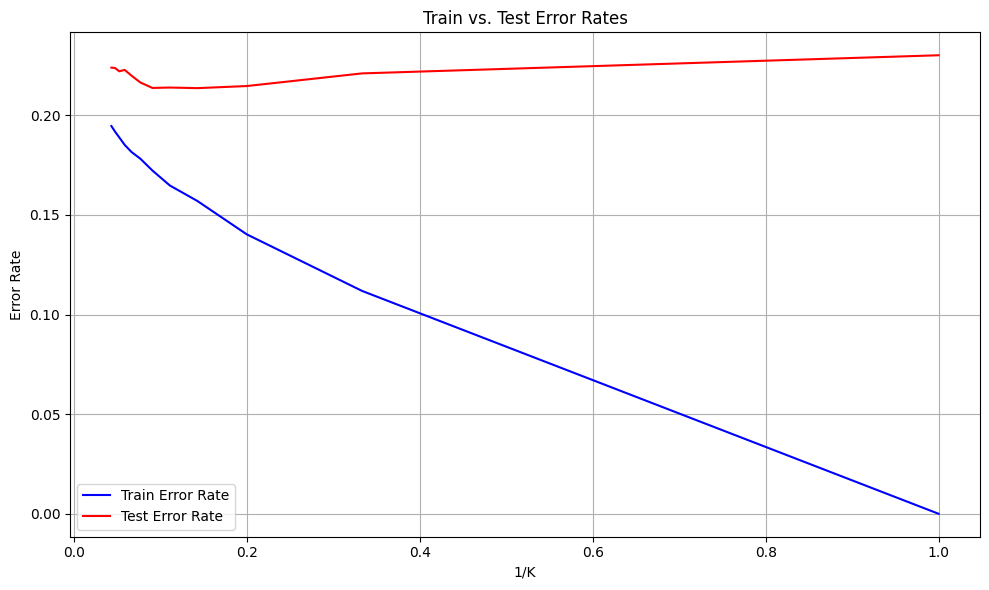

In [293]:
# Show that KNN estimation has following pattern:
# 1) training error decreases as 1/K increases
# 2) test error first decreases and then increases as 1/K (flexibility) increases

# Create a double line graph
plt.figure(figsize=(10, 6))

# Plot train error rates
plt.plot(k_ratios, error_training_rate, label='Train Error Rate', color='blue')

# Plot test error rates
plt.plot(k_ratios, error_test_rate, label='Test Error Rate', color='red')
plt.xlabel('1/K')
plt.ylabel('Error Rate')
plt.title('Train vs. Test Error Rates')
plt.legend()

# Show the plot
plt.grid()
plt.show()

In [294]:
# Question 3)

# Using training data only, draw a figure with:
# 1 and 2 types of error rates as a function of classification threshold
# 3) the overall error rate as a function of the classification threshold
# Replicate figure 4.7 for training set
thresholds = np.arange(0, 1.02, 0.02)
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
tpr_test = []
fpr_test = []
fnr_test = []
error_rate_test = []
y_test_probs = knn.predict_proba(X_test)[:, 1]
for threshold in thresholds:
    # Apply threshold to probabilities to get binary predictions
    y_test_pred = (y_test_probs >= threshold).astype(int)
    
    # Calculate confusion matrices
    cm_test = confusion_table(y_test, y_test_pred)
    
    # Calculate TPR, FPR, and error rates
    tn_test, fp_test, fn_test, tp_test = [cm_test[0][0], cm_test[0][1], cm_test[1][0], cm_test[1][1]]
    tpr_test.append(tp_test / (tp_test + fn_test))
    fpr_test.append(fp_test / (fp_test + tn_test))
    fnr_test.append(fn_test / (fn_test + tp_test))
    error_rate_test.append((fp_test + fn_test) / len(y_test))

# Draw an additional figure of the ROC curve (figure 4.8)

/var/folders/jn/v2jdn4p97ms6j6kbs3y53tsc0000gn/T/ipykernel_8519/38572217.py:25: RuntimeWarning: invalid value encountered in scalar divide
  fpr_test.append(fp_test / (fp_test + tn_test))


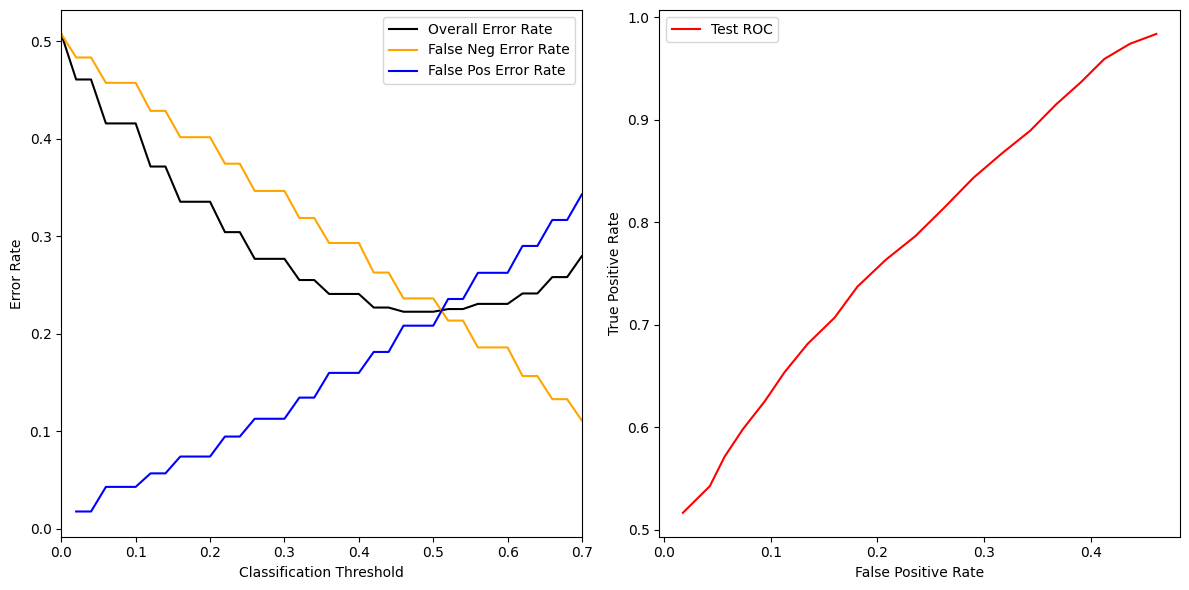

In [295]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(thresholds, error_rate_test, label='Overall Error Rate', color='black')
plt.plot(thresholds, fnr_test, label='False Neg Error Rate', color='orange')
plt.plot(thresholds, fpr_test, label='False Pos Error Rate', color='blue')
plt.xlim(0, 0.7)
plt.xlabel('Classification Threshold')
plt.ylabel('Error Rate')
plt.legend()

# Plot the ROC curve:
plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, label='Test ROC', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [296]:
# Read in test dataset
testData = pd.read_csv('./Econ_424_F2023_PC3_test_without_response_variable.csv')
# label encoder to encode the different categorical features
label_encoder = LabelEncoder()
for category in categorical_columns:
    testData[category] = label_encoder.fit_transform(testData[category])

featuresNew = testData
print(featuresNew)
# Scaler stuff
scalerNew = StandardScaler(with_mean=True, with_std=True,copy=True)
scalerNew.fit(featuresNew)
X_stdNew = scalerNew.transform(featuresNew)
feature_std_new = pd.DataFrame(X_stdNew ,columns=featuresNew.columns)
print("feature std:")
print(feature_std_new.std())
print(feature_std_new)
# regular
print("printing regular features")
print(X)

# Make Predictions on the Test Set
Y_Test = bestModel.predict(feature_std_new)



       year  mileage  city  state  make  model
0      2011    78669  1725      5     5     49
1      2016    14932  1440      5    48   2076
2      2014    53001   216      6    25    900
3      2013    64502  1561     51    10     30
4      2016    15295   992     18    22   1397
...     ...      ...   ...    ...   ...    ...
99995  2011   144092   787     49    15   1730
99996  2015    24318   817      5     9    381
99997  2015    26221    43     49    39    205
99998  2015    28131  1766     49    29    578
99999  2016    13049   492     49     9   1763

[100000 rows x 6 columns]
feature std:
year       1.000005
mileage    1.000005
city       1.000005
state      1.000005
make       1.000005
model      1.000005
dtype: float64
           year   mileage      city     state      make     model
0     -0.667320  0.613869  0.701092 -1.322691 -1.264938 -1.587816
1      0.794972 -0.889776  0.301807 -1.322691  1.499019  1.838920
2      0.210055  0.008325 -1.413015 -1.264669  0.020624 -0.1491

In [297]:
print(Y_Test)
print(len(Y_Test))

[1 1 0 ... 1 0 0]
100000


In [302]:
# output prediction results in csv
# Specify the file path where you want to save the CSV
csv_file = "./output.csv"


# Use numpy.savetxt to save the array as a CSV file
np.savetxt(csv_file, Y_Test, delimiter="\n", fmt="%1d")

In [299]:
Y_Train = bestModel.predict(feature_std)
print(accuracy_score(Y_Train,y))
C = confusion_table(Y_Train,y)
total_predictions = C[0][0] + C[0][1] + C[1][0] + C[1][1]
false_positives = C[0][1]
false_negatives = C[1][0]
curr_error = (false_positives + false_negatives) / total_predictions
error_test_rate.append(curr_error)

0.83169


In [300]:
print(c)

Truth         0     1
Predicted            
0          7965  2230
1          2190  7615


TypeError: float() argument must be a string or a real number, not 'ellipsis'

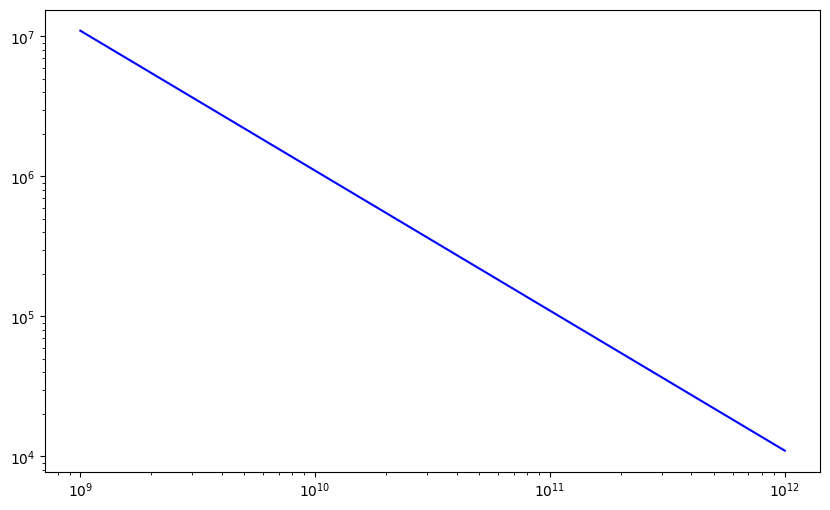

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Define constants
sigma = 5.67e-8  # Stefan-Boltzmann constant in W/(m^2 K^4)
A = 0.1  # Albedo
L_sun = 3.828e26  # Solar luminosity in watts
d_sun = 1.496e11  # Average Earth-Sun distance in meters

# Create an array of distances from the Sun (in meters)
distances = np.logspace(9, 12, num=100, base=10)  # 1e9 to 1e12 meters

# Calculate equilibrium temperatures for the grey planet
equilibrium_temperatures = np.sqrt((1 - A) * L_sun / (16 * np.pi * sigma * distances**2))

# Plot equilibrium temperatures
plt.figure(figsize=(10, 6))
plt.loglog(distances, equilibrium_temperatures, label="Equilibrium Temperature", color='blue')

# Add data for observed surface temperatures and distances of planets
# You would need to provide this data or load it from a dataset.

# Example data (distance in meters and temperature in Kelvin)
planet_distances = [1.496e11, ...]  # Replace with actual data
planet_temperatures = [288, ...]  # Replace with actual data

# Plot observed data
plt.scatter(planet_distances, planet_temperatures, label="Observed Temperatures", color='red')

# Label axes and add a legend
plt.xlabel("Distance from Sun (meters)")
plt.ylabel("Temperature (K)")
plt.legend()

# Add a title and display the plot
plt.title("Equilibrium Temperature vs. Observed Temperatures of Planets")
plt.grid(True, which="both", ls="--", c='gray')
plt.show()
